In [1]:
import warnings
warnings.filterwarnings('ignore')

# Croatian Verb classsification

authors: Rebeka Čorić, Domagoj Ševerdija, Lucian Šošić

## Problem definition

In this paper we present croatian verb classification from infinitive form to present form and vice-versa. In both cases convolutional Neural Network is employed to learn classifer.

## Problem 1: Infinitive stem classification

In [2]:
from inf2pres.evaluate import evaluateOnTestSet, loadModel, heatmap, predict
from inf2pres.utils         import ucitajPodatke, klase_prezent

### Dataset

Dataset consists of pairs $(w_{inf},C_{pres})$ where $w_{inf}$ denotes infinitive form of verb $w$ and $C_{pres}\in \{-am,-im,-ijem,-jem,-em\}$ as a class denoted with respect to 1st person present suffix.


In [3]:
train_set, val_set, test_set, sve_kategorije = ucitajPodatke('inf2pres/data/')

In [4]:
import pandas as pd
train_df = pd.DataFrame(train_set,columns=['word','class'])
val_df   = pd.DataFrame(val_set,columns=['word','class'])
test_df  = pd.DataFrame(test_set,columns=['word','class'])


stats = pd.DataFrame(data = 
                     {'classes' : klase_prezent.values(), 
                      'train' : train_df['class'].value_counts(), 
                      'val' : val_df['class'].value_counts(),
                      'test' : test_df['class'].value_counts()},                                          
                      
        ).set_index('classes')

        
stats.loc['total']= stats.sum(numeric_only=True, axis=0)
stats.loc[:,'total']= stats.sum(numeric_only=True, axis=1)


print(stats.to_latex(index=True))

stats


\begin{tabular}{lrrrr}
\toprule
{} &  train &  val &  test &  total \\
classes &        &      &       &        \\
\midrule
am      &   1968 &  219 &   243 &   2430 \\
im      &   1900 &  212 &   235 &   2347 \\
ijem    &    975 &  109 &   121 &   1205 \\
jem     &    537 &   60 &    67 &    664 \\
em      &     81 &    9 &    10 &    100 \\
total   &   5461 &  609 &   676 &   6746 \\
\bottomrule
\end{tabular}



,train,val,test,total
classes,,,,
am,1968,219,243,2430
im,1900,212,235,2347
ijem,975,109,121,1205
jem,537,60,67,664
em,81,9,10,100
total,5461,609,676,6746


#### Model evaluation

Our model is evaluated in terms of accuracy, micro-  and macro-averages of F1 socres together with weigthed $F_1$ score. We report a confusion matrix. 

 --------------Evaluation metrics: ----------------------           
 * test loss: 1.423
 * test accuracy: 0.947,
 * test rmse: 0.683,
 * test microF1: 0.879,
 * test macroF1: 0.947,
 * test weightedF1: 0.946


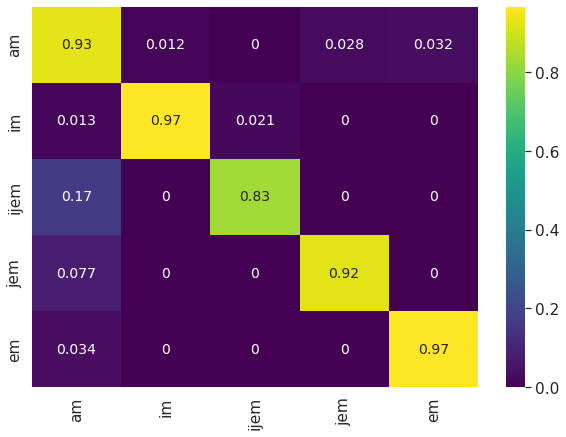

In [11]:
# evaluacija prethodno spremljenog modela
model_weights_path = 'inf2pres/results/hyperparameters/hp2/model.weights'
model = loadModel(model_weights_path)
evaluateOnTestSet(model, test_set,sve_kategorije)

### Model testing

Some interesting examples with an interpretation.

In [19]:
%%writefile inf2pres.input
iscrtati
raskrinkati
slušati
primjeriti
bubriti
iskoračiti
klijati
skijati
postojati
ustrajati
stajati
prijati
pridavati
mučati
zibati
škrabati
muvati
dokazati
zezati
pogledavati
razgranavati
poravnavati
dozidavati
podrivati
ispitivati
poštivati
isplaćivati
označivati
zapinjati
proklinjati
prokleti
izasuti
otpasti
ozepsti
skupsti
pomusti
potaći
zapovrći
vrći
zaleći
zaspati
proliti
vapiti
sazreti
prozreti
mljeti
zadjeti
rudjeti
osoviti
mokriti
oviti
raspoloviti
požeti
uzavreti
odaslati
prohtjeti
nadići
isklesati
zabosti
zderati
poodmaći
dopirati
okretati
susresti
obrecnuti
umirati

Overwriting inf2pres.input


INF2PRES class: am


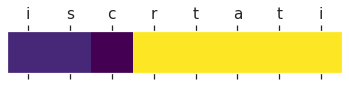

INF2PRES class: am


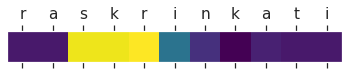

INF2PRES class: am


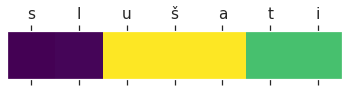

INF2PRES class: im


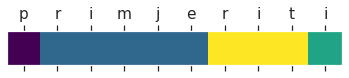

INF2PRES class: im


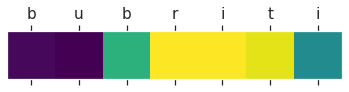

INF2PRES class: im


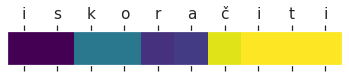

INF2PRES class: am


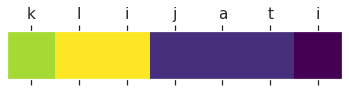

INF2PRES class: am


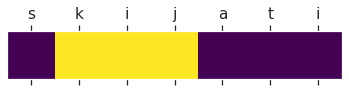

INF2PRES class: im


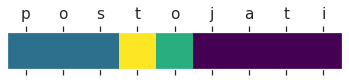

INF2PRES class: jem


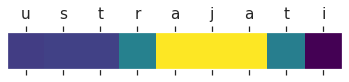

INF2PRES class: jem


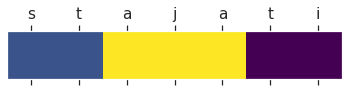

INF2PRES class: ijem


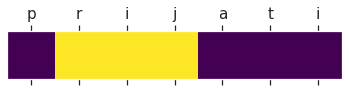

INF2PRES class: jem


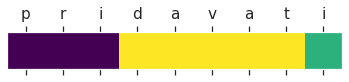

INF2PRES class: im


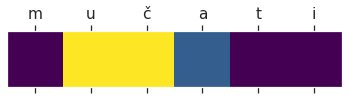

INF2PRES class: am


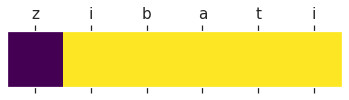

INF2PRES class: am


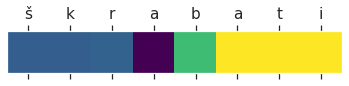

INF2PRES class: am


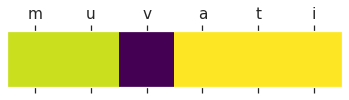

INF2PRES class: em


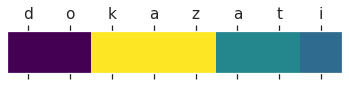

INF2PRES class: am


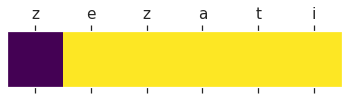

INF2PRES class: am


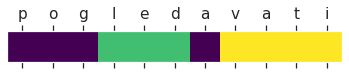

INF2PRES class: am


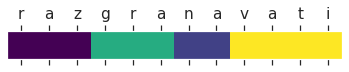

INF2PRES class: am


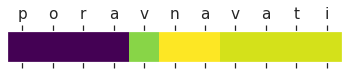

INF2PRES class: am


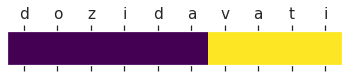

INF2PRES class: am


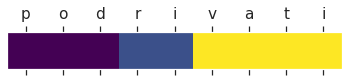

INF2PRES class: jem


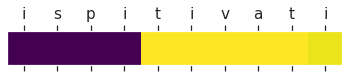

INF2PRES class: jem


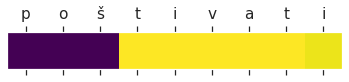

INF2PRES class: jem


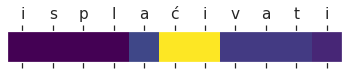

INF2PRES class: jem


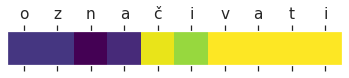

INF2PRES class: jem


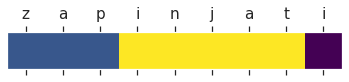

INF2PRES class: jem


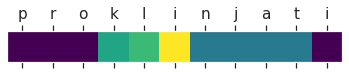

INF2PRES class: em


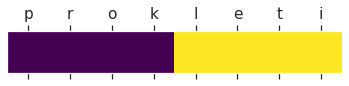

INF2PRES class: em


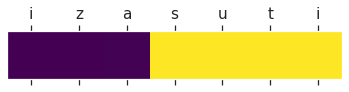

INF2PRES class: em


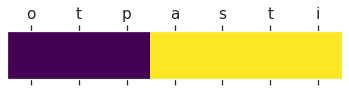

INF2PRES class: em


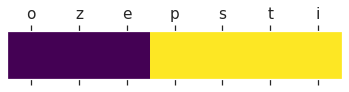

INF2PRES class: em


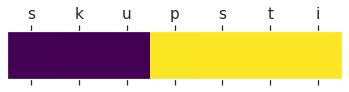

INF2PRES class: em


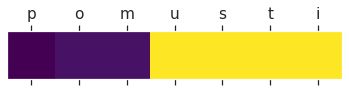

INF2PRES class: em


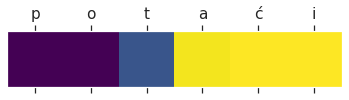

INF2PRES class: em


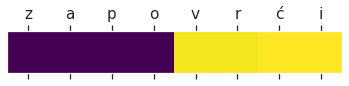

INF2PRES class: em


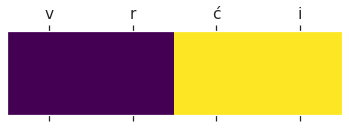

INF2PRES class: em


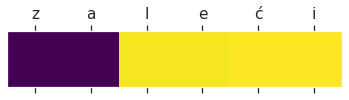

INF2PRES class: im


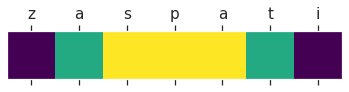

INF2PRES class: ijem


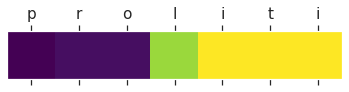

INF2PRES class: im


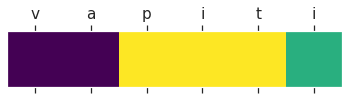

INF2PRES class: em


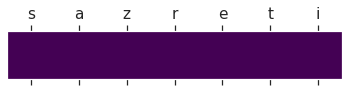

INF2PRES class: em


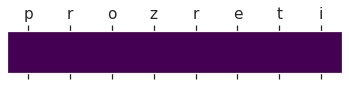

INF2PRES class: jem


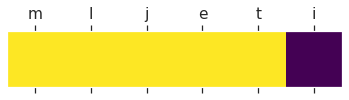

INF2PRES class: im


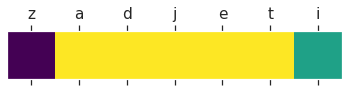

INF2PRES class: im


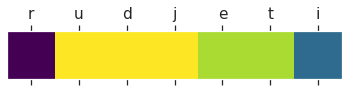

INF2PRES class: im


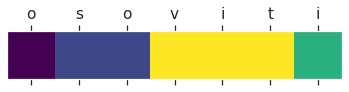

INF2PRES class: im


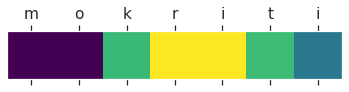

INF2PRES class: ijem


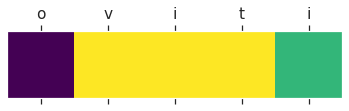

INF2PRES class: im


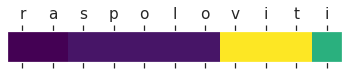

INF2PRES class: jem


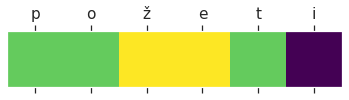

INF2PRES class: im


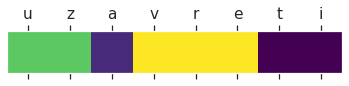

INF2PRES class: jem


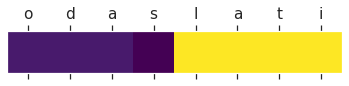

INF2PRES class: ijem


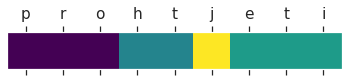

INF2PRES class: em


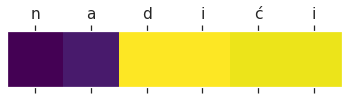

INF2PRES class: em


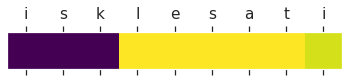

INF2PRES class: em


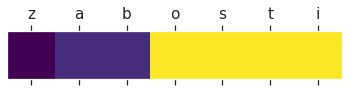

INF2PRES class: em


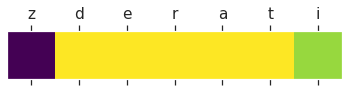

INF2PRES class: em


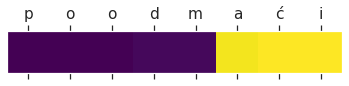

INF2PRES class: em


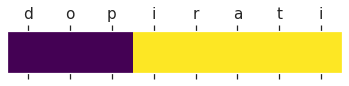

INF2PRES class: em


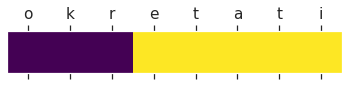

INF2PRES class: em


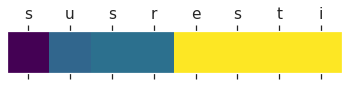

INF2PRES class: em


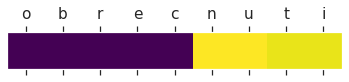

INF2PRES class: am


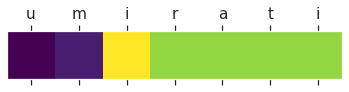

In [12]:
with open('inf2pres.input') as f:
    glagoli = f.read().splitlines()
    
#napravi heatmap
_ = [heatmap(model,gl) for gl in glagoli ]

## Problem 2: Present stem classification

In [1]:
from pres2inf.evaluate import evaluateOnTestSet, loadModel, heatmap
from pres2inf.utils         import ucitajPodatke, klase_infinitiv

### Dataset

In [2]:
# dataset
train_set, val_set, test_set, sve_kategorije = ucitajPodatke('pres2inf/data/')

In [3]:
import pandas as pd
train_df = pd.DataFrame(train_set,columns=['word','class'])
val_df   = pd.DataFrame(val_set,columns=['word','class'])
test_df  = pd.DataFrame(test_set,columns=['word','class'])


stats = pd.DataFrame(data = 
                     {'classes' : klase_infinitiv.values(), 
                      'train' : train_df['class'].value_counts(), 
                      'val' : val_df['class'].value_counts(),
                      'test' : test_df['class'].value_counts()},                                          
                      
        ).set_index('classes')

        
stats.loc['total']= stats.sum(numeric_only=True, axis=0)
stats.loc[:,'total']= stats.sum(numeric_only=True, axis=1)

print(stats.to_latex(index=True))

stats

\begin{tabular}{lrrrr}
\toprule
{} &  train &  val &  test &  total \\
classes &        &      &       &        \\
\midrule
ati     &   2936 &  328 &   363 &   3627 \\
iti     &   1752 &  195 &   217 &   2164 \\
ijeti   &     27 &    4 &     4 &     35 \\
jeti    &    153 &   18 &    20 &    191 \\
eti     &     33 &    4 &     5 &     42 \\
uti     &    332 &   37 &    42 &    411 \\
ći      &    101 &   12 &    13 &    126 \\
total   &   5334 &  598 &   664 &   6596 \\
\bottomrule
\end{tabular}



,train,val,test,total
classes,,,,
ati,2936,328,363,3627
iti,1752,195,217,2164
ijeti,27,4,4,35
jeti,153,18,20,191
eti,33,4,5,42
uti,332,37,42,411
ći,101,12,13,126
total,5334,598,664,6596


### Model evaluation

 --------------Evaluation metrics: ----------------------           
 * test loss: 4.371
 * test accuracy: 0.935,
 * test rmse: 0.660,
 * test microF1: 0.765,
 * test macroF1: 0.935,
 * test weightedF1: 0.928


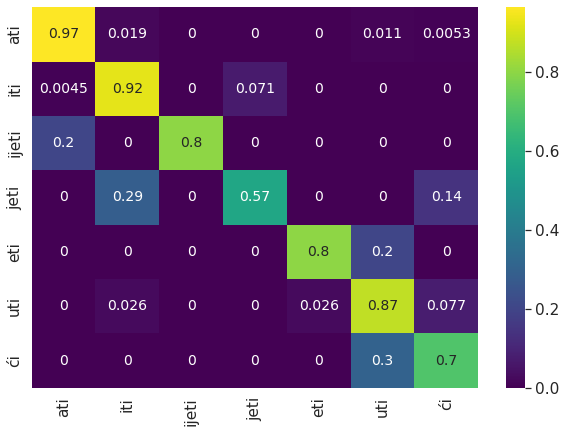

In [4]:
# evaluacija prethodno spremljenog modela
model_weights_path = 'pres2inf/results/hyperparameters/hp2/model.weights'
model = loadModel(model_weights_path)
evaluateOnTestSet(model, test_set,sve_kategorije)

### Model testing

In [5]:
%%writefile pres2inf.input
kroatiziram
peckam
promiješam
potpisujem
uneređujem
sperem

Overwriting pres2inf.input


PRES2INF class: ati


/home/dseverdi/Radno/morphology/HR_verb_classification/pres2inf/evaluate.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + nazivi)


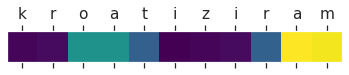

PRES2INF class: ati


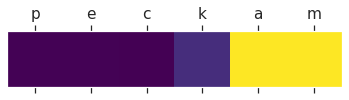

PRES2INF class: ati


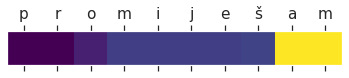

PRES2INF class: ati


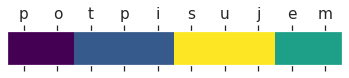

PRES2INF class: ati


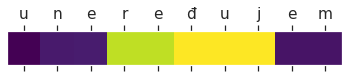

PRES2INF class: ati


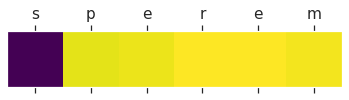

In [6]:
with open('pres2inf.input') as f:
    glagoli = f.read().splitlines()
    

#napravi heatmap
_ = [heatmap(gl,model) for gl in glagoli ]